In [3]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [4]:
%cd /gdrive/My Drive/Colab Notebooks/Polimi_ANDL/Homework_1

/gdrive/My Drive/Colab Notebooks/Polimi_ANDL/Homework_1


In [5]:
import os
import shutil
import glob
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from PIL import Image



tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)



2.9.2


In [36]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [39]:
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

In [7]:
tf.config.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
# Each species' pictures are stored in a separate directory which
# names are as follows:
labels = [
    "Species1",
    "Species2",
    "Species3",
    "Species4",
    "Species5",
    "Species6",
    "Species7",
    "Species8"
]

In [8]:
dataset_dir = "res/images"

## How many images per species ?

Text(0.5, 1.0, 'Number of training pictures per species')

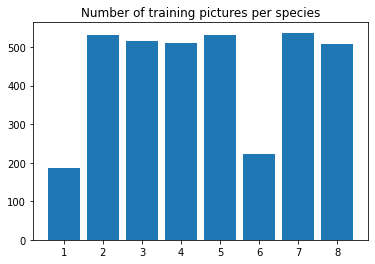

In [9]:
label_counts = []
for species in labels:
    label_counts.append(len(os.listdir("{}/{}/".format(dataset_dir, species))))

plt.bar(np.arange(1,9), label_counts)
plt.title("Number of training pictures per species")

## To sum up:
### 3542 pictures of which:
- 186 of species 1
- 532 of species 2
- 515 of species 3
- 511 of species 4
- 531 of species 5
- 222 of species 6
- 537 of species 7
- 508 of species 8

Of size (96 x 96) pixels encoded in RGB space (depth = 3 channels)

### Input $ I \in \{0, 1, 2 ... 255\}^{96 \times 96 \times 3}$
### Output $ K \in [0;1]^{8} $

# Data loading and augmentation


## Creating the training/validation split of the dataset


In [10]:
dataset_dir=os.getcwd()+'/res'
validation_split=0.1
num_species=8

In [11]:
# DO IT ONCE (?) BUT CAN BE REDO IF NEEDED

#Splitting equally for each species

# train_subset=[]
# valid_subset=[]

# def create_folders():
#     path_train=os.path.join(dataset_dir,'training')
#     path_valid=os.path.join(dataset_dir,'validation')
#     isExist_train = os.path.exists(path_train)
#     isExist_valid = os.path.exists(path_valid)
#     if (isExist_train==False):
#         os.mkdir(path_train)
#     if (isExist_valid==False):
#         os.mkdir(path_valid)
    
#     for i in range(1,num_species+1):
#         path_train_i=os.path.join(dataset_dir,'training/Species'+str(i))
#         path_valid_i=os.path.join(dataset_dir,'validation/Species'+str(i))
#         isExist_train_i = os.path.exists(path_train_i)
#         isExist_valid_i = os.path.exists(path_valid_i)
#         if (isExist_train_i==False):
#             os.mkdir(path_train_i)
#         if (isExist_valid_i==False):
#             os.mkdir(path_valid_i)
    



# def clear_folder(mydir):
#     filelist = [ f for f in os.listdir(mydir) ]
#     for f in filelist:
#         os.remove(os.path.join(mydir, f))


# create_folders()


# for i in range(1,num_species+1):
    
#     training_species_i=os.path.join(dataset_dir,'training/Species'+str(i))
#     valid_species_i=os.path.join(dataset_dir,'validation/Species'+str(i))
#     clear_folder(training_species_i)
#     clear_folder(valid_species_i)
    
#     filenames = next(os.walk(os.path.join(dataset_dir,'images/Species'+str(i))))[2]
#     np.random.shuffle(filenames)
#     num_valid_samples = int(len(filenames)*validation_split)
#     add_to_train=filenames[:-num_valid_samples]
#     add_to_valid=filenames[-num_valid_samples:]
#     train_subset = train_subset+add_to_train
#     valid_subset = valid_subset+add_to_valid
#     for name in add_to_train:
#         shutil.copy(os.path.join(dataset_dir,'images/Species'+str(i)+'/'+name),training_species_i)    
#     for name in add_to_valid:
#         shutil.copy(os.path.join(dataset_dir,'images/Species'+str(i)+'/'+name),valid_species_i)
    
    
        

# print(len(train_subset))
# print(len(valid_subset))
# print(len(train_subset)+len(valid_subset))

    


3191
351
3542


In [12]:
training_dir = os.path.join(dataset_dir, 'training')
validation_dir = os.path.join(dataset_dir, 'validation')

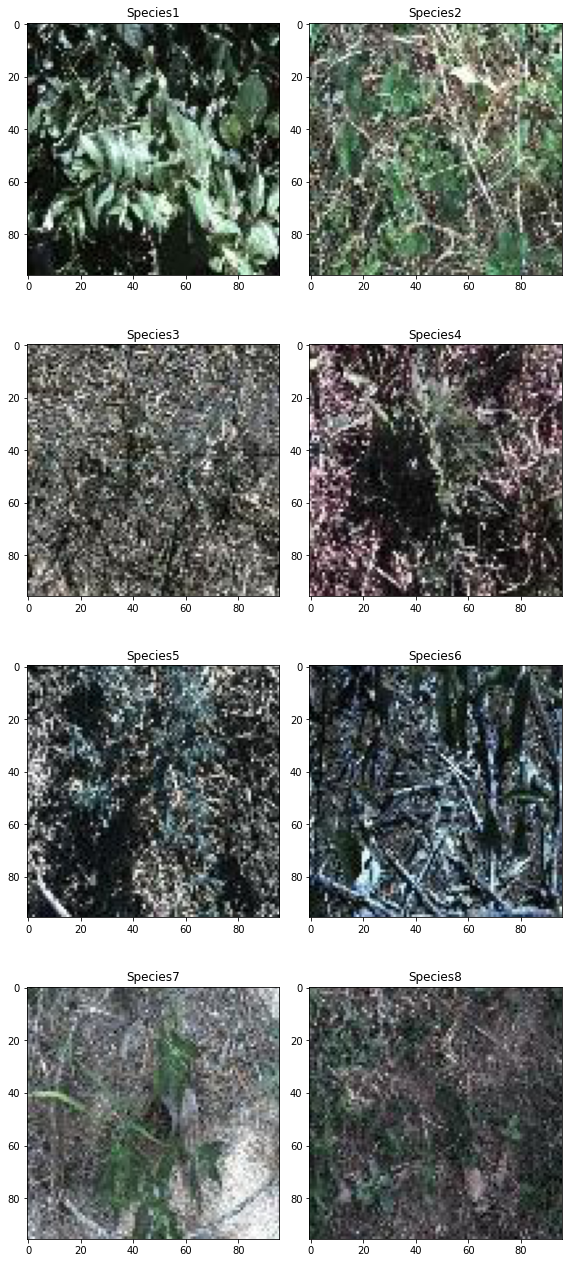

In [13]:
#vizualising data 

labels = ['Species1','Species2','Species3','Species4','Species5','Species6','Species7','Species8',]        # 20

num_row = 4
num_col = 2
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,9*num_col))
for i in range(num_row*num_col):
  if i < 8:
    class_imgs = next(os.walk('{}/training/{}/'.format(dataset_dir, labels[i])))[2]
    class_img = class_imgs[0]
    img = Image.open('{}/training/{}/{}'.format(dataset_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator for training, validation, and test sets
train_data_gen = ImageDataGenerator()
valid_data_gen = ImageDataGenerator()
test_data_gen = ImageDataGenerator()


# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the 
# ImageDataGenerator to read them from disk.
   

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = train_data_gen.flow_from_directory(directory=training_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=True)
valid_gen = train_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=False)


Found 3191 images belonging to 8 classes.
Found 351 images belonging to 8 classes.


In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator for training, validation, and test sets
train_data_gen = ImageDataGenerator()
valid_data_gen = ImageDataGenerator()
test_data_gen = ImageDataGenerator()


# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the 
# ImageDataGenerator to read them from disk.
   

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = train_data_gen.flow_from_directory(directory=training_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=True)
valid_gen = train_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=False)


Found 3191 images belonging to 8 classes.
Found 351 images belonging to 8 classes.


In [16]:
def get_next_batch(generator):
  batch = next(generator)

  image = batch[0]
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  # Visualize only the first sample
  image = image[0]
  target = target[0]
  target_idx = np.argmax(target)
  print()
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(np.uint8(image))

  return batch

(Input) image shape: (8, 96, 96, 3)
Target shape: (8, 8)

Categorical label: [0. 0. 0. 1. 0. 0. 0. 0.]
Label: 3
Class name: Species4


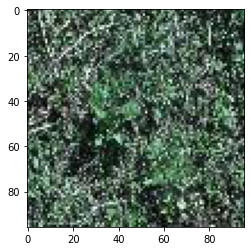

In [17]:
# Get a sample from dataset and show info
_ = get_next_batch(train_gen)

## Data Augmentation

In [18]:
# tf.keras.preprocessing.image.ImageDataGenerator(
#     featurewise_center=False, samplewise_center=False,
#     featurewise_std_normalization=False, samplewise_std_normalization=False,
#     zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0,
#     height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0,
#     channel_shift_range=0.0, fill_mode='nearest', cval=0.0,
#     horizontal_flip=False, vertical_flip=False, rescale=None,
#     preprocessing_function=None, data_format=None, validation_split=0.0, dtype=None
# )

Rotation: {'theta': -16.375048902742073, 'tx': 0, 'ty': 0, 'shear': 0, 'zx': 1, 'zy': 1, 'flip_horizontal': 0, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None} 

Shift: {'theta': 0, 'tx': 0, 'ty': -15, 'shear': 0, 'zx': 1, 'zy': 1, 'flip_horizontal': 0, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None} 

Zoom: {'theta': 0, 'tx': 0, 'ty': 0, 'shear': 0, 'zx': 0.7916007632298978, 'zy': 1.1664300837049235, 'flip_horizontal': 0, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None} 

Flip: {'theta': 0, 'tx': 0, 'ty': 0, 'shear': 0, 'zx': 1, 'zy': 1, 'flip_horizontal': 1, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None} 



Text(0.5, 1.0, 'Flipped')

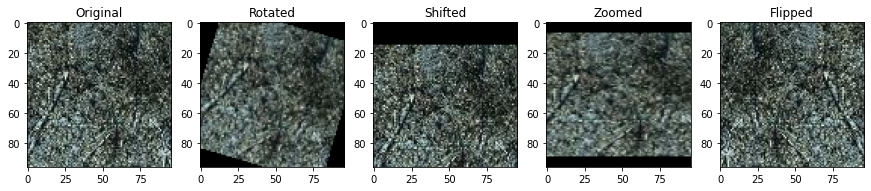

In [19]:
# Create some augmentation examples
# Get sample image
image = next(train_gen)[0][4]

# Create an instance of ImageDataGenerator for each transformation
rot_gen = ImageDataGenerator(rotation_range=30)
shift_gen = ImageDataGenerator(width_shift_range=50)
zoom_gen = ImageDataGenerator(zoom_range=0.3)
flip_gen = ImageDataGenerator(horizontal_flip=True)

# Get random transformations
rot_t = rot_gen.get_random_transform(img_shape=(96,96))
print('Rotation:', rot_t, '\n')
shift_t = shift_gen.get_random_transform(img_shape=(96,96))
print('Shift:', shift_t, '\n')
zoom_t = zoom_gen.get_random_transform(img_shape=(96,96))
print('Zoom:', zoom_t, '\n')
flip_t = flip_gen.get_random_transform(img_shape=(96,96))
print('Flip:', flip_t, '\n')

# Apply the transformation
gen = ImageDataGenerator(fill_mode='constant', cval=0.)
rotated = gen.apply_transform(image, rot_t)
shifted = gen.apply_transform(image, shift_t) 
zoomed = gen.apply_transform(image, zoom_t) 
flipped = gen.apply_transform(image, flip_t)  

# Plot original and augmented images
fig, ax = plt.subplots(1, 5, figsize=(15, 45))
ax[0].imshow(np.uint8(image))
ax[0].set_title('Original')
ax[1].imshow(np.uint8(rotated))
ax[1].set_title('Rotated')
ax[2].imshow(np.uint8(shifted))
ax[2].set_title('Shifted')
ax[3].imshow(np.uint8(zoomed))
ax[3].set_title('Zoomed')
ax[4].imshow(np.uint8(flipped))
ax[4].set_title('Flipped')

# Training with and without data augmentation

In [20]:
# Create an instance of ImageDataGenerator with NO Data Augmentation
noaug_train_data_gen = ImageDataGenerator(rescale=1/255.) # rescale value is multiplied to the image
valid_data_gen = ImageDataGenerator(rescale=1/255.)
test_data_gen = ImageDataGenerator(rescale=1/255.)

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
noaug_train_gen = noaug_train_data_gen.flow_from_directory(directory=training_dir,
                                                           target_size=(96,96),
                                                           color_mode='rgb',
                                                           classes=None, # can be set to labels
                                                           class_mode='categorical',
                                                           batch_size=8,
                                                           shuffle=True,
                                                           )
valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=False,
                                               )

Found 3191 images belonging to 8 classes.
Found 351 images belonging to 8 classes.


In [21]:
# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(rotation_range=30,
                                        height_shift_range=50,
                                        width_shift_range=50,
                                        zoom_range=0.3,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='reflect',
                                        rescale=1/255.) # rescale value is multiplied to the image

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(96,96),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=8,
                                                       shuffle=True,
                                                       )

Found 3191 images belonging to 8 classes.


In [22]:
input_shape = (96, 96, 3)
epochs = 200

In [23]:
def build_model(input_shape):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    conv1 = tfkl.Conv2D(
        filters=32,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform()
    )(input_layer)
    pool1 = tfkl.MaxPooling2D()(conv1)

    conv2 = tfkl.Conv2D(
        filters=64,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform()
    )(pool1)
    pool2 = tfkl.MaxPooling2D()(conv2)

    conv3 = tfkl.Conv2D(
        filters=128,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform()
    )(pool2)
    pool3 = tfkl.MaxPooling2D()(conv3)

    conv4 = tfkl.Conv2D(
        filters=256,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform()
    )(pool3)
    pool4 = tfkl.MaxPooling2D()(conv4)

    conv5 = tfkl.Conv2D(
        filters=512,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform()
    )(pool4)
    pool5 = tfkl.MaxPooling2D()(conv5)

    flattening_layer = tfkl.Flatten(name='Flatten')(pool5)
    dropout = tfkl.Dropout(0.3)(flattening_layer)
    classifier_layer = tfkl.Dense(units=512, name='Classifier', kernel_initializer=tfk.initializers.HeUniform(), activation='relu')(dropout)
    dropout = tfkl.Dropout(0.3)(classifier_layer)
    output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(), name='output_layer')(dropout)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [24]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('data_augmentation_experiments')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=True, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

In [25]:
# Build model (for NO augmentation training)
model = build_model(input_shape)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       73856 

In [32]:
# Create folders and callbacks and fit
noaug_callbacks = create_folders_and_callbacks(model_name='CNN_NoAug')

# Train the model
history = model.fit(
    x = noaug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = noaug_callbacks ,
).history

Epoch 1/200
399/399 [==============================] - 12s 31ms/step - loss: 0.3275 - accuracy: 0.8856 - val_loss: 1.4459 - val_accuracy: 0.5869
Epoch 2/200
399/399 [==============================] - 12s 31ms/step - loss: 0.2582 - accuracy: 0.9157 - val_loss: 1.9411 - val_accuracy: 0.5670
Epoch 3/200
399/399 [==============================] - 12s 31ms/step - loss: 0.2456 - accuracy: 0.9235 - val_loss: 1.8589 - val_accuracy: 0.5983
Epoch 4/200
399/399 [==============================] - 13s 32ms/step - loss: 0.2777 - accuracy: 0.9107 - val_loss: 1.8842 - val_accuracy: 0.5812
Epoch 5/200
399/399 [==============================] - 14s 34ms/step - loss: 0.1936 - accuracy: 0.9311 - val_loss: 2.3456 - val_accuracy: 0.5926
Epoch 6/200
399/399 [==============================] - 13s 31ms/step - loss: 0.2348 - accuracy: 0.9248 - val_loss: 2.3196 - val_accuracy: 0.5356
Epoch 7/200
399/399 [==============================] - 13s 31ms/step - loss: 0.2628 - accuracy: 0.9129 - val_loss: 2.0182 - val_ac

In [41]:
# Save best epoch model
model.save("data_augmentation_experiments/CNN_NoAug_Best")